# Compute encoding change across conditions

In [1]:
%env JAX_DEBUG_NANS=false
%env CUDA_VISIBLE_DEVICES=1
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.95

# import os
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"   # no big upfront grab
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"    # or a small fraction
# # Optional: better allocator for sharing
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


# public libraries
import jax
import jax.tree_util as jtu
import jax.numpy as jnp
import jax.scipy.stats.norm as norm
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import seaborn as sns
from scipy import stats
from scipy.special import softmax
import h5py
import numpy as np
from genjax.typing import FloatArray
from genjax import ChoiceMap
import itertools
import os

key = jax.random.PRNGKey(314159)

env: JAX_DEBUG_NANS=false
env: CUDA_VISIBLE_DEVICES=1
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.95


In [2]:
# flavell lab libraries
import flv_utils as flv

import cepnem_jax as cj
from cepnem_jax import (
    prob_P_greater_Q,
    benjamini_hochberg,
    compute_AND,
    neuron_p_values,
    compute_ζ,
    compute_s,
    CePNEM_120, 
    get_CePNEM_data
)

def compute_α(α0):
    return norm.cdf(α0)
    
def compute_σSE(σ0_SE):
    return σ_SE_MEAN * jnp.exp(σ0_SE * σ_SE_STD)

def compute_σnoise(σ0_noise):
    return σ_NOISE_MEAN * jnp.exp(σ0_noise * σ_NOISE_STD)

Sourcing files from flv-c servers


/storage/fs/store1/candy/candy_cepnem/private_cepnem_jax/.venv/lib/python3.12/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(


In [3]:
def effective_gains(c_vT, c_v, c_th, c_P, s):
    """Compute 6 effective gains (v, θh, P for v>=0 and v<0)."""
    denom = jnp.sqrt(c_vT**2 + 1.0)
    r_pos = (c_vT + 1.0) / denom
    r_neg = (1.0 - c_vT) / denom

    g_v  = c_v  / (s + 1.0)
    g_th = c_th / (s + 1.0)
    g_P  = c_P  / (s + 1.0)

    g_pos = jnp.array([r_pos * g_v, r_pos * g_th, r_pos * g_P])
    g_neg = jnp.array([r_neg * g_v, r_neg * g_th, r_neg * g_P])

    return jnp.concatenate([g_pos, g_neg])  # shape (6,)


def effective_gains_from_posterior(posterior: dict):
    """
    Compute effective gains for all posterior samples.
    
    Args:
        posterior: dict with keys "c_vT", "c_v", "c_theta_h", "c_P", "s".
                   Each value is an array of shape (n_samples,) or (n_chains, n_samples).
    
    Returns:
        Array of shape (..., 6) containing effective gains per sample.
    """
    c_vT = posterior["c_vT"].reshape(-1)
    c_v  = posterior["c_v"].reshape(-1)
    c_th = posterior["c_θh"].reshape(-1)
    c_P  = posterior["c_P"].reshape(-1)

    if "s" in posterior.keys():
        s = posterior["s"].reshape(-1)
    else:
        s = compute_s(posterior["s0"]).reshape(-1)
        
    # Vectorize over all leading dimensions of the arrays
    batched_effective_gains = jax.vmap(effective_gains)
    return batched_effective_gains(c_vT, c_v, c_th, c_P, s)


# # Test case
# posterior = {
#     "c_vT": jnp.array([0.5, -1.2]),
#     "c_v":  jnp.array([1.0, 0.8]),
#     "c_θh": jnp.array([0.3, 0.5]),
#     "c_P":  jnp.array([2.1, 1.9]),
#     "s":    jnp.array([5.0, 4.0])
# }

# gains = effective_gains_from_posterior(posterior)
# print(gains.shape)  # (2, 6)
# print(gains)

In [6]:
def compare_distributions(distribution_0, distribution_1):

    len_0 = len(distribution_0)
    len_1 = len(distribution_1)
    
    if len_0 == 1:
        is_greater = distribution_0[0] < distribution_1
        is_smaller = distribution_0[0] > distribution_1
        n = len_1
        
    elif len_1 == 1:
        is_greater = distribution_0 < distribution_1[0]
        is_smaller = distribution_0 > distribution_1[0]        
        n = len_0
        
    else:
        n = np.min([len_0, len_1])
        is_greater = distribution_0[:n] < distribution_1[:n]
        is_smaller = distribution_0[:n] > distribution_1[:n]
        
    p_greater = 1 - sum(is_greater) / n
    p_smaller = 1 - sum(is_smaller) / n
    
    return np.min([p_greater, p_smaller])


def benjamini_hochberg_correction(p_values):
    """
    Apply Benjamini-Hochberg correction to control false discovery rate (FDR).
    
    Parameters:
    p_values: array-like, dict, or nested dict of p-values
    
    Returns:
    corrected_p_values: same structure as input, containing BH-corrected p-values
    """
    # Handle dictionary inputs
    if isinstance(p_values, dict):
        return _bh_correction_dict(p_values)
    
    # Handle array-like inputs
    return _bh_correction_array(p_values)

def _bh_correction_dict(p_dict):
    """
    Handle dictionary and nested dictionary inputs.
    """
    # Collect all p-values and their paths
    all_p_values = []
    paths = []
    
    def collect_values(d, current_path=""):
        for key, value in d.items():
            new_path = f"{current_path}.{key}" if current_path else str(key)
            
            if isinstance(value, dict):
                # Nested dictionary - recurse
                collect_values(value, new_path)
            elif isinstance(value, (int, float, np.number)):
                # Single p-value
                all_p_values.append(float(value))
                paths.append(new_path)
            elif hasattr(value, '__iter__') and not isinstance(value, str):
                # Array-like value
                value_array = np.array(value).flatten()
                for i, v in enumerate(value_array):
                    all_p_values.append(float(v))
                    paths.append(f"{new_path}[{i}]")
            else:
                raise ValueError(f"Unsupported value type at {new_path}: {type(value)}")
    
    collect_values(p_dict)
    
    # Apply BH correction to all collected p-values
    corrected_flat = _bh_correction_array(np.array(all_p_values))
    
    # Reconstruct the original structure with corrected values
    corrected_dict = {}
    path_to_corrected = dict(zip(paths, corrected_flat))
    
    def reconstruct_dict(d, current_path=""):
        result = {}
        for key, value in d.items():
            new_path = f"{current_path}.{key}" if current_path else str(key)
            
            if isinstance(value, dict):
                # Nested dictionary
                result[key] = reconstruct_dict(value, new_path)
            elif isinstance(value, (int, float, np.number)):
                # Single p-value
                result[key] = path_to_corrected[new_path]
            elif hasattr(value, '__iter__') and not isinstance(value, str):
                # Array-like value - reconstruct original shape
                original_array = np.array(value)
                flat_size = original_array.size
                corrected_values = [path_to_corrected[f"{new_path}[{i}]"] 
                                  for i in range(flat_size)]
                result[key] = np.array(corrected_values).reshape(original_array.shape)
        
        return result
    
    return reconstruct_dict(p_dict)

def _bh_correction_array(p_values):
    """
    Apply BH correction to array-like p-values.
    """
    # Convert to numpy array and store original shape
    p_array = np.array(p_values)
    original_shape = p_array.shape
    
    # Flatten for processing
    p_flat = p_array.flatten()
    n = len(p_flat)
    
    if n == 0:
        return p_array
    
    # Get sorting indices (ascending order)
    sorted_indices = np.argsort(p_flat)
    
    # Sort p-values
    p_sorted = p_flat[sorted_indices]
    
    # Calculate BH correction: p_adjusted = p * n / rank
    # rank goes from 1 to n (not 0 to n-1)
    ranks = np.arange(1, n + 1)
    p_adjusted = p_sorted * n / ranks
    
    # Ensure monotonicity (corrected p-values should be non-decreasing)
    # Work backwards through the sorted array
    for i in range(n - 2, -1, -1):
        if p_adjusted[i] > p_adjusted[i + 1]:
            p_adjusted[i] = p_adjusted[i + 1]
    
    # Cap at 1.0 (p-values cannot exceed 1)
    p_adjusted = np.minimum(p_adjusted, 1.0)
    
    # Create output array and restore original order
    corrected_p_values = np.empty_like(p_flat)
    corrected_p_values[sorted_indices] = p_adjusted
    
    # Reshape back to original dimensions
    return corrected_p_values.reshape(original_shape)

def array_to_dict_with_indices(arr):
    """
    Convert an array to a dictionary where keys correspond to array indices.
    Supports 1D, 2D, 3D, and higher dimensional arrays.
    """
    arr = np.array(arr)
    
    if arr.ndim == 1:
        # 1D array: {0: val0, 1: val1, ...}
        return {i: arr[i] for i in range(len(arr))}
    
    elif arr.ndim == 2:
        # 2D array: {0: {0: val00, 1: val01}, 1: {0: val10, 1: val11}, ...}
        return {i: {j: arr[i, j] for j in range(arr.shape[1])} 
                for i in range(arr.shape[0])}
    
    elif arr.ndim == 3:
        # 3D array: {0: {0: {0: val000, 1: val001}, 1: {0: val010, 1: val011}}, ...}
        return {i: {j: {k: arr[i, j, k] for k in range(arr.shape[2])} 
                    for j in range(arr.shape[1])} 
                for i in range(arr.shape[0])}
    
    else:
        # Higher dimensions - flatten to 1D with multi-index keys
        flat_arr = arr.flatten()
        result = {}
        for idx, val in enumerate(flat_arr):
            multi_idx = np.unravel_index(idx, arr.shape)
            # Create nested dict structure
            current_dict = result
            for dim_idx in multi_idx[:-1]:
                if dim_idx not in current_dict:
                    current_dict[dim_idx] = {}
                current_dict = current_dict[dim_idx]
            current_dict[multi_idx[-1]] = val
        
        return result

def dict_to_array_values(d, original_shape):
    """
    Extract values from nested dictionary back to array format.
    """
    def extract_values(nested_dict):
        if isinstance(nested_dict, dict):
            values = []
            for key in sorted(nested_dict.keys()):
                values.extend(extract_values(nested_dict[key]))
            return values
        else:
            return [nested_dict]
    
    flat_values = extract_values(d)
    return np.array(flat_values).reshape(original_shape)

def run_test_case(test_name, array_data):
    """
    Run a test case comparing array vs dictionary BH correction.
    """
    print(f"\n{'='*60}")
    print(f"TEST: {test_name}")
    print(f"{'='*60}")
    
    # Convert array to dictionary
    dict_data = array_to_dict_with_indices(array_data)
    
    print(f"Original array shape: {np.array(array_data).shape}")
    print(f"Original array:\n{np.array(array_data)}")
    print(f"\nCorresponding dictionary:")
    print(dict_data)
    
    # Apply BH correction to both
    corrected_array = benjamini_hochberg_correction(array_data)
    corrected_dict = benjamini_hochberg_correction(dict_data)
    
    # Convert dictionary results back to array for comparison
    dict_as_array = dict_to_array_values(corrected_dict, corrected_array.shape)
    
    print(f"\nBH corrected array:\n{corrected_array}")
    print(f"\nBH corrected dictionary values as array:\n{dict_as_array}")
    
    # Check if they're equal
    are_equal = np.allclose(corrected_array, dict_as_array, rtol=1e-10, atol=1e-15)
    print(f"\nResults are {'IDENTICAL' if are_equal else 'DIFFERENT'}")
    
    if not are_equal:
        print(f"Maximum difference: {np.max(np.abs(corrected_array - dict_as_array))}")
    
    return are_equal

## Load results

In [75]:
all_conditions = ['dense_food', 'sparse_food', 'diacetyl', 'just_fed', 'fasted', 'starved', 'octanol', 'heat_stim', 'gfp', 'scrambled']

dict_color = dict()
dict_color['dense_food']  = 'saddlebrown'
dict_color['sparse_food'] = 'darkorange'
dict_color['diacetyl']    = 'deeppink'
dict_color['just_fed']    = 'dodgerblue'
dict_color['fasted']      = 'lightseagreen'
dict_color['starved']     = 'darkgreen'
dict_color['octanol']     = 'navy'
dict_color['copper']      = 'purple'
dict_color['heat_stim']   = 'darkred'
dict_color['gfp']         = 'lightgrey'
dict_color['scrambled']   = 'black'

In [90]:
# nc = 'AVA'
full_model_dir = '/store1/candy/candy_cepnem/candy_testing/om_fits_120/2025-09-01'
control = 'scrambled'
# list_nc = ['AVA', 'RMG']

dict_G = dict()

for nc in flv.fig4_neuron_classes:
    if not os.path.isdir(f'{full_model_dir}/{nc}'):
        print(f'{nc} not found')
        continue
    
    dict_G[nc] = dict()

    # compute effective gains from control condition
    path_output = f'{full_model_dir}/{nc}/{control}.h5'
    result = flv.h5_to_dict(path_output)
    output = result['CePNEMOutput']
    posterior = output['posterior_samples']
    dict_G[nc][control] = effective_gains_from_posterior(posterior)    
    
    for condition in all_conditions:

        if condition == control: 
            continue
            
        elif condition == 'diacetyl':
            path_output = f'{full_model_dir}/{nc}/just_fed.h5'

        else:
            path_output = f'{full_model_dir}/{nc}/{condition}.h5'
            
        if not os.path.isfile(path_output):
            print(f'{nc} not found for {condition}')
            continue
            
        result = flv.h5_to_dict(path_output)
        output = result['CePNEMOutput']
        posterior = output['posterior_samples']
        dict_G[nc][condition] = effective_gains_from_posterior(posterior)

AIA not found
AVL not found
RIF not found
RIR not found
RIP not found
SAADR not found
SMBD not found
SIAV not found
SIAD not found
SIBV not found
SIBD not found
AFD not found
I4 not found
I5 not found
I6 not found


(array([1.5044e+04, 3.3880e+03, 0.0000e+00, 9.0000e+00, 5.5900e+02,
        4.5900e+03, 6.7900e+03, 2.2020e+03, 1.7700e+02, 9.0000e+00]),
 array([0.09434117, 0.18744071, 0.28054023, 0.37363976, 0.4667393 ,
        0.55983883, 0.65293837, 0.7460379 , 0.83913743, 0.93223697,
        1.0253365 ]),
 <BarContainer object of 10 artists>)

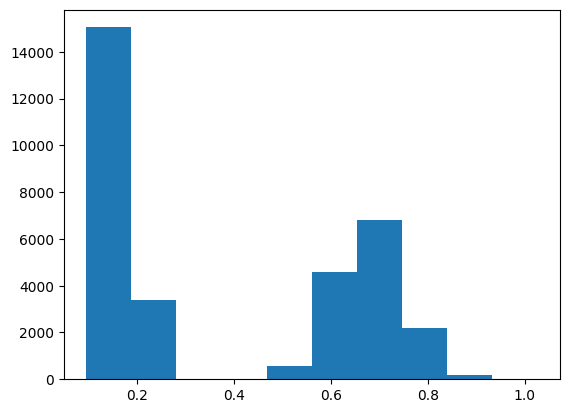

In [77]:
nc = 'NSM'
group = 'dense_food'
path_output = f'{full_model_dir}/{nc}/{group}.h5'
result = flv.h5_to_dict(path_output)
output = result['CePNEMOutput']
posterior = output['posterior_samples']
plt.hist(posterior['c_P'].flatten())

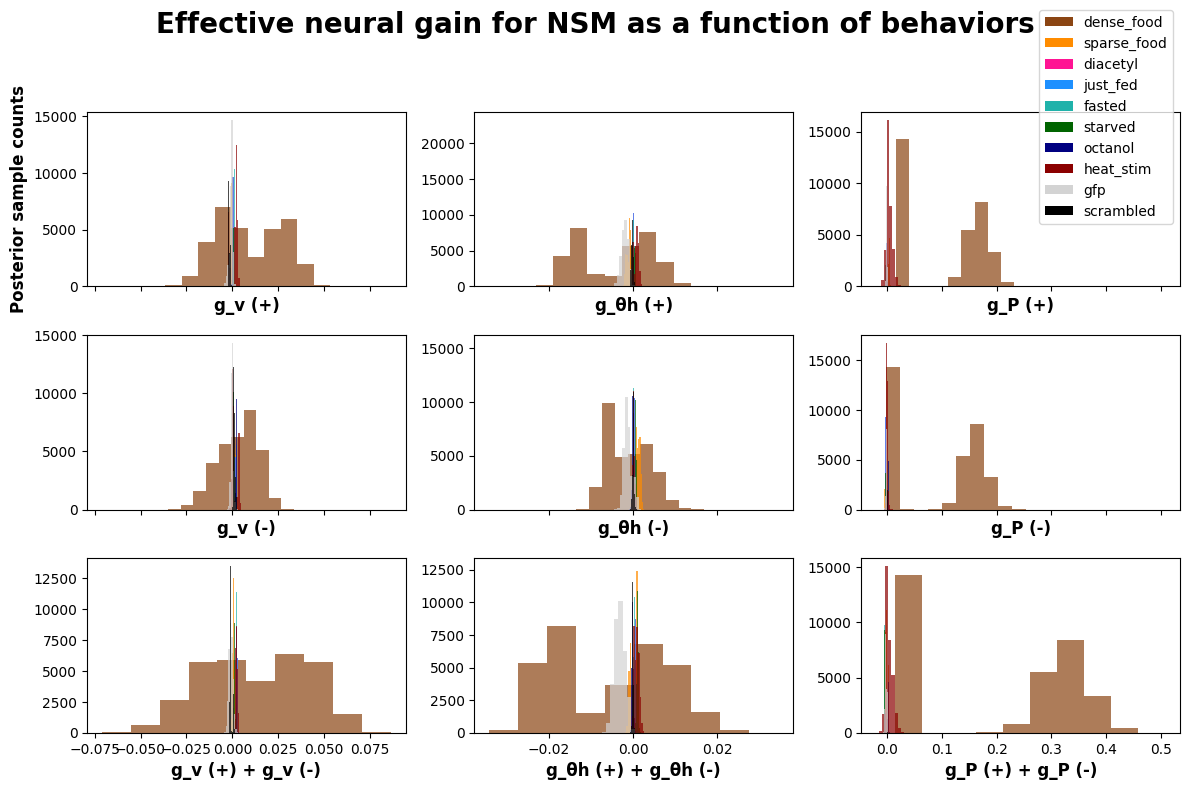

In [91]:
# Create figure with subplots (3 rows, 3 columns) with shared x-axis per column
fig, axes = plt.subplots(3, 3, figsize=(12, 8), sharex='col')

# Neuron class
nc = 'NSM'

# Define the xlabel order
xlabels = ['g_v (+)', 'g_θh (+)', 'g_P (+)', 'g_v (-)', 'g_θh (-)', 'g_P (-)']

# Loop through each g_idx for the first 6 subplots
for plot_idx, g_idx in enumerate(range(6)):
    row = plot_idx // 3
    col = plot_idx % 3
    ax = axes[row, col]
    
    # Plot histograms for each condition
    for condition in all_conditions:
        ax.hist(dict_G[nc][condition][:,g_idx], 
                color=dict_color[condition], alpha=0.7, 
                label=f"{condition}")
    
    # Set labels for each subplot
    ax.set_xlabel(xlabels[plot_idx], fontweight='bold', fontsize=12)
    if plot_idx == 0:
        ax.set_ylabel('Posterior sample counts', fontweight='bold', fontsize=12)

# Add sum distributions in the third row
sum_labels = ['g_v (+) + g_v (-)', 'g_θh (+) + g_θh (-)', 'g_P (+) + g_P (-)']
sum_pairs = [(0, 3), (1, 4), (2, 5)]  # Pairs of indices to sum

for sum_idx, (idx1, idx2) in enumerate(sum_pairs):
    ax = axes[2, sum_idx]  # Third row subplots
    
    # Plot histograms for each condition
    for condition in all_conditions:
        # Sum the corresponding positive and negative components
        sum_data = dict_G[nc][condition][:,idx1] + dict_G[nc][condition][:,idx2]
        ax.hist(sum_data, 
                color=dict_color[condition], alpha=0.7, 
                label=f"{condition}")
    
    # Set labels for sum subplots
    ax.set_xlabel(sum_labels[sum_idx], fontweight='bold', fontsize=12)

# Add legend only to the first subplot, positioned outside
legend = axes[0, 2].legend(bbox_to_anchor=(1, 0.97), loc='right')
# Set legend alpha to 1 (fully opaque)
for patch in legend.get_patches():
    patch.set_alpha(1)

# Adjust layout to prevent legend cutoff
plt.tight_layout()
# Add extra space on the right for legends
# plt.subplots_adjust(right=0.95)

# Overall title for the entire figure
fig.suptitle(f'Effective neural gain for {nc} as a function of behaviors', 
             fontweight='bold', fontsize=20, y=0.98)

plt.show()

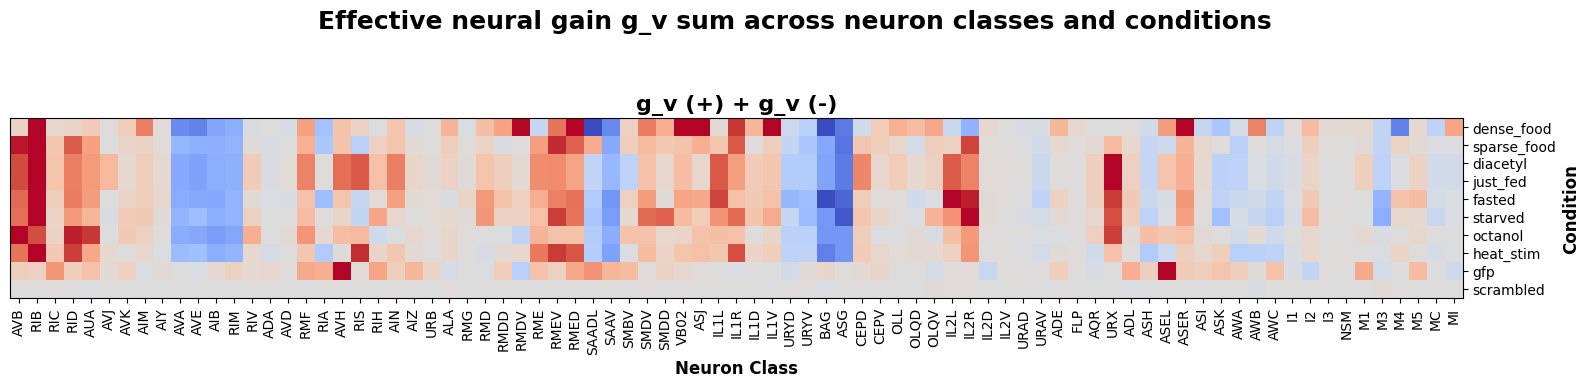

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of neuron classes
neuron_classes = flv.fig4_neuron_classes

# Create figure for single heatmap
fig, ax = plt.subplots(figsize=(16, 4))

# Initialize matrices to store mean values for heatmap
# Rows: conditions, Columns: neuron classes
n_conditions = len(all_conditions)
n_nc = len(neuron_classes)

gv_pos_matrix = np.full((n_conditions, n_nc), np.nan)
gv_neg_matrix = np.full((n_conditions, n_nc), np.nan)

# Fill the matrices with mean values, handling missing keys
for nc_idx, nc in enumerate(neuron_classes):
    # Check if neuron class exists in dict_G
    if nc not in dict_G:
        continue  # Skip this neuron class, leave NaN values
    
    for cond_idx, condition in enumerate(all_conditions):
        # Check if condition exists for this neuron class
        if condition not in dict_G[nc]:
            continue  # Skip this condition, leave NaN value
        
        # Check if the data array has the expected shape
        data = dict_G[nc][condition]
        if data.shape[1] > 0:  # g_v(+) is at index 0
            gv_pos_matrix[cond_idx, nc_idx] = np.mean(data[:, 0])
        if data.shape[1] > 3:  # g_v(-) is at index 3
            gv_neg_matrix[cond_idx, nc_idx] = np.mean(data[:, 3])

# Create sum matrix
gv_sum_matrix = gv_pos_matrix + gv_neg_matrix

# Find columns that are not all NaN
valid_columns = ~np.all(np.isnan(gv_sum_matrix), axis=0)
valid_nc_indices = np.where(valid_columns)[0]
valid_neuron_classes = [neuron_classes[i] for i in valid_nc_indices]

# Filter the matrix to only include valid columns
gv_sum_matrix_filtered = gv_sum_matrix[:, valid_columns]

# Create custom colormap with white for NaN values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

# Create single heatmap
im = ax.imshow(gv_sum_matrix_filtered, cmap=cmap, aspect='equal', vmin=-0.25, vmax=0.25)

# Set title
ax.set_title('g_v (+) + g_v (-)', fontweight='bold', fontsize=16)

# Set x-axis labels (neuron classes) - rotated 90 degrees
ax.set_xticks(range(len(valid_neuron_classes)))
ax.set_xticklabels(valid_neuron_classes, rotation=90)
ax.set_xlabel('Neuron Class', fontweight='bold', fontsize=12)

# Set y-axis labels (conditions) on the right
ax.set_yticks(range(n_conditions))
ax.set_yticklabels(all_conditions)
ax.set_ylabel('Condition', fontweight='bold', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Mean g_v (+) + g_v (-)', fontweight='bold', fontsize=12)

# # Add value annotations on heatmap (only for non-NaN values)
# for i in range(n_conditions):
#     for j in range(n_nc):
#         if not np.isnan(gv_sum_matrix[i, j]):
#             ax.text(j, i, f'{gv_sum_matrix[i, j]:.3f}', 
#                     ha='center', va='center', color='white', fontweight='bold')

# Overall title
fig.suptitle('Effective neural gain g_v sum across neuron classes and conditions', 
             fontweight='bold', fontsize=18, y=0.95)

plt.tight_layout()
plt.show()

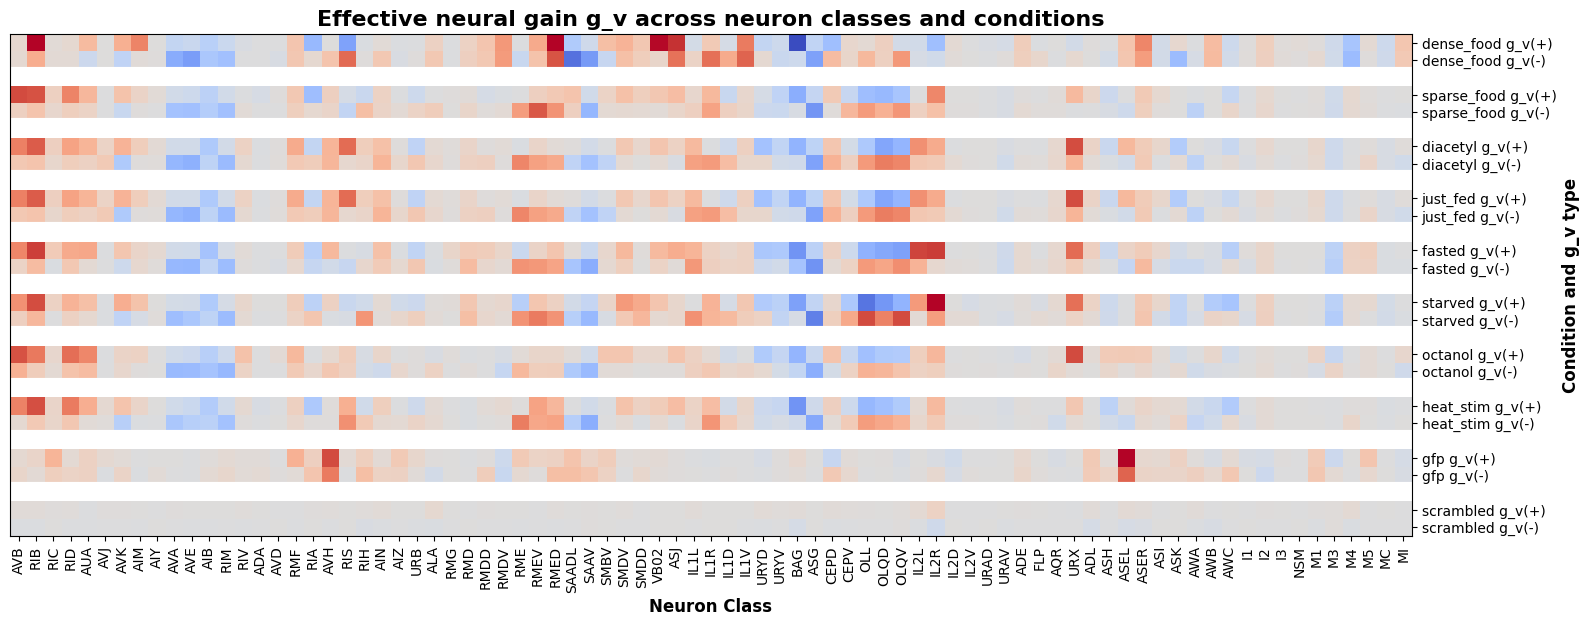

In [93]:
# Alternative: Single heatmap with g_v(+) and g_v(-) as consecutive row pairs per condition
fig2, ax = plt.subplots(figsize=(16, 9))

# Create matrix with gaps: (2 * n_conditions + gaps) x n_nc
# We'll add a gap row between each condition pair
gap_size = 1
total_rows = 2 * n_conditions + (n_conditions - 1) * gap_size
combined_matrix = np.full((total_rows, n_nc), np.nan)  # Use NaN for gaps

# Fill the matrix with g_v values
row_labels = []
row_positions = []
current_row = 0

for cond_idx, condition in enumerate(all_conditions):
    # Add g_v(+) row
    for nc_idx, nc in enumerate(neuron_classes):
        # Check if neuron class and condition exist
        if nc in dict_G and condition in dict_G[nc]:
            data = dict_G[nc][condition]
            if data.shape[1] > 0:  # Check if index 0 exists
                combined_matrix[current_row, nc_idx] = np.mean(data[:, 0])  # g_v(+)
    row_labels.append(f'{condition} g_v(+)')
    row_positions.append(current_row)
    current_row += 1
    
    # Add g_v(-) row
    for nc_idx, nc in enumerate(neuron_classes):
        # Check if neuron class and condition exist
        if nc in dict_G and condition in dict_G[nc]:
            data = dict_G[nc][condition]
            if data.shape[1] > 3:  # Check if index 3 exists
                combined_matrix[current_row, nc_idx] = np.mean(data[:, 3])  # g_v(-)
    row_labels.append(f'{condition} g_v(-)')
    row_positions.append(current_row)
    current_row += 1
    
    # Add gap row (except after the last condition)
    if cond_idx < n_conditions - 1:
        current_row += gap_size

# Find columns that are not all NaN
valid_columns2 = ~np.all(np.isnan(combined_matrix), axis=0)
valid_nc_indices2 = np.where(valid_columns2)[0]
valid_neuron_classes2 = [neuron_classes[i] for i in valid_nc_indices2]

# Filter the matrix to only include valid columns
combined_matrix_filtered = combined_matrix[:, valid_columns2]

# Create custom colormap with white for NaN values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

im = ax.imshow(combined_matrix_filtered, cmap=cmap, aspect='equal', vmin=-0.25, vmax=0.25)

# Set x-axis labels (neuron classes) - rotated 90 degrees
ax.set_xticks(range(len(valid_neuron_classes2)))
ax.set_xticklabels(valid_neuron_classes2, rotation=90)
ax.set_xlabel('Neuron Class', fontweight='bold', fontsize=12)

# Set y-axis labels (only for actual data rows, not gap rows) on the right
ax.set_yticks(row_positions)
ax.set_yticklabels(row_labels)
ax.set_ylabel('Condition and g_v type', fontweight='bold', fontsize=12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Mean g_v', fontweight='bold', fontsize=12)

# # Add value annotations (only for non-NaN values)
# for i in range(total_rows):
#     for j in range(n_nc):
#         if not np.isnan(combined_matrix[i, j]):
#             ax.text(j, i, f'{combined_matrix[i, j]:.3f}', 
#                     ha='center', va='center', color='white', fontweight='bold')

# Add horizontal lines to separate condition groups
for cond_idx in range(n_conditions - 1):
    y_position = 2 * (cond_idx + 1) + cond_idx * gap_size - 0.5
    ax.axhline(y=y_position, color='white', linewidth=3)

plt.title('Effective neural gain g_v across neuron classes and conditions', 
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

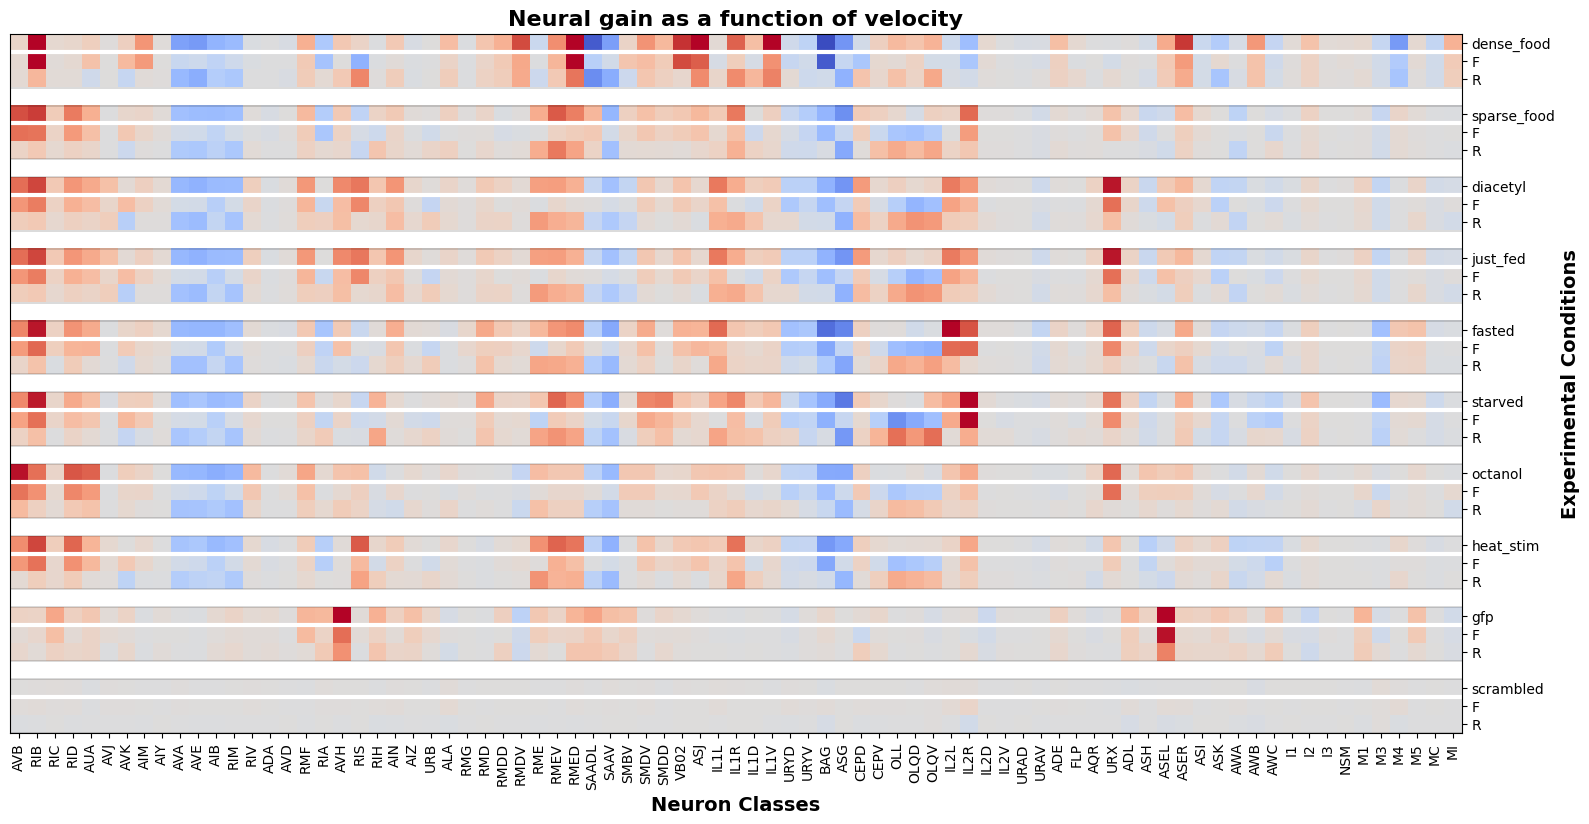

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of neuron classes
neuron_classes = flv.fig4_neuron_classes

# Create figure for combined heatmap
fig, ax = plt.subplots(figsize=(16, 12))

# Initialize matrices to store mean values
n_conditions = len(all_conditions)
n_nc = len(neuron_classes)
gv_pos_matrix = np.full((n_conditions, n_nc), np.nan)
gv_neg_matrix = np.full((n_conditions, n_nc), np.nan)

# Fill the matrices with mean values, handling missing keys
for nc_idx, nc in enumerate(neuron_classes):
    # Check if neuron class exists in dict_G
    if nc not in dict_G:
        continue  # Skip this neuron class, leave NaN values
    
    for cond_idx, condition in enumerate(all_conditions):
        # Check if condition exists for this neuron class
        if condition not in dict_G[nc]:
            continue  # Skip this condition, leave NaN value
        
        # Check if the data array has the expected shape
        data = dict_G[nc][condition]
        if data.shape[1] > 0:  # g_v(+) is at index 0
            gv_pos_matrix[cond_idx, nc_idx] = np.mean(data[:, 0])
        if data.shape[1] > 3:  # g_v(-) is at index 3
            gv_neg_matrix[cond_idx, nc_idx] = np.mean(data[:, 3])

# Create sum matrix
gv_sum_matrix = gv_pos_matrix + gv_neg_matrix

# Create combined matrix with gaps: (3 * n_conditions + gaps) x n_nc
# Each condition will have 3 rows: sum, g_v(+), g_v(-)
gap_size = 1
total_rows = 3 * n_conditions + (n_conditions - 1) * gap_size
combined_matrix = np.full((total_rows, n_nc), np.nan)  # Use NaN for gaps

# Fill the matrix with values
row_labels = []
row_positions = []
current_row = 0

for cond_idx, condition in enumerate(all_conditions):
    # Add sum row
    combined_matrix[current_row] = gv_sum_matrix[cond_idx]
    row_labels.append(f'{condition}')
    row_positions.append(current_row)
    current_row += 1
    
    # Add g_v(+) row
    combined_matrix[current_row] = gv_pos_matrix[cond_idx]
    row_labels.append('F')
    row_positions.append(current_row)
    current_row += 1
    
    # Add g_v(-) row
    combined_matrix[current_row] = gv_neg_matrix[cond_idx]
    row_labels.append('R')
    row_positions.append(current_row)
    current_row += 1
    
    # Add gap row (except after the last condition)
    if cond_idx < n_conditions - 1:
        current_row += gap_size

# Find columns that are not all NaN
valid_columns = ~np.all(np.isnan(combined_matrix), axis=0)
valid_nc_indices = np.where(valid_columns)[0]
valid_neuron_classes = [neuron_classes[i] for i in valid_nc_indices]

# Filter the matrix to only include valid columns
combined_matrix_filtered = combined_matrix[:, valid_columns]

# Create custom colormap with white for NaN values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

# Create heatmap
im = ax.imshow(combined_matrix_filtered, cmap=cmap, aspect='equal', vmin=-0.3, vmax=0.3)

# Set x-axis labels (neuron classes) - rotated 90 degrees
ax.set_xticks(range(len(valid_neuron_classes)))
ax.set_xticklabels(valid_neuron_classes, rotation=90)
ax.set_xlabel('Neuron Classes', fontweight='bold', fontsize=14)

# Set y-axis labels (only for actual data rows, not gap rows) on the right
ax.set_yticks(row_positions)
ax.set_yticklabels(row_labels)
ax.set_ylabel('Experimental Conditions', fontweight='bold', fontsize=14)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Mean g_v Value', fontweight='bold', fontsize=12)

# Add horizontal lines within each condition group
for cond_idx in range(n_conditions):
    base_row = 3 * cond_idx + cond_idx * gap_size if cond_idx > 0 else 0
    ax.axhline(y=base_row - 0.5, color='black', linewidth=0.2)
    # Line between sum (first row) and g_v(+)/g_v(-) (last two rows)
    ax.axhline(y=base_row + 0.5, color='white', linewidth=3)
    ax.axhline(y=base_row + 2.5, color='black', linewidth=0.2)

plt.title('Neural gain as a function of velocity', 
          fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()

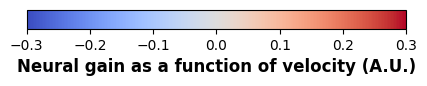

In [95]:
import matplotlib.pyplot as plt
import numpy as np

# Create a separate figure just for the colorbar
fig, ax = plt.subplots(figsize=(5, 2))

# Create custom colormap with white for NaN values
cmap = plt.cm.coolwarm.copy()
cmap.set_bad(color='white')

# Create a dummy mappable object for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-0.3, vmax=0.3))
sm.set_array([])

# Create horizontal colorbar
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal')
cbar.set_label('Neural gain as a function of velocity (A.U.)', fontweight='bold', fontsize=12)

# Hide the axes
ax.set_visible(False)

plt.tight_layout()
plt.show()

## Compute a single metric from the 6 effective gain (transformed CePNEM parameters) per condition per neuron class

In [ ]:
# Optional SciPy speed-up for triangular solves (falls back to NumPy if missing)
try:
    from scipy.linalg import solve_triangular as _tri_solve
    def tri_solve(L, B):  # L is lower-triangular, solve L Y = B
        return _tri_solve(L, B, lower=True, check_finite=False, overwrite_b=False)
except Exception:
    def tri_solve(L, B):
        # Generic solver; fine at this 6x6 size
        return np.linalg.solve(L, B)

def _clean_rows(X):
    """Keep only rows that are fully finite."""
    m = np.isfinite(X).all(axis=1)
    return X[m], m

def _cholesky_with_adaptive_ridge(S, ridge0=1e-6, max_tries=6):
    """
    Ensure PD by adding ridge*I; if Cholesky fails, grow ridge by x10 up to max_tries.
    Returns (L, used_ridge) with S_reg = L @ L.T.
    """
    I = np.eye(S.shape[0], dtype=S.dtype)
    ridge = ridge0
    for _ in range(max_tries):
        try:
            L = np.linalg.cholesky(S + ridge * I)
            return L, ridge
        except np.linalg.LinAlgError:
            ridge *= 10.0
    # Final attempt with a big ridge so we fail loudly if something is truly wrong
    L = np.linalg.cholesky(S + ridge * I)
    return L, ridge

def fit_ref_params_cpu(X_ref, shrink=0.0, ridge=1e-6):
    """
    Estimate reference mean and a PD covariance (via shrink + adaptive ridge).
    X_ref: (n_ref, 6) numpy array (CPU)
    shrink: 0..1 diagonal shrinkage toward diag(S)
    ridge: initial ridge; will be increased automatically if needed
    Returns:
        mu_ref: (6,)
        L: lower Cholesky factor of Σ_ref (so Σ_ref = L @ L.T)
        used_ridge: ridge actually applied after adaptation
    """
    X_ref = np.asarray(X_ref)
    X_ref, mask = _clean_rows(X_ref)
    if X_ref.shape[0] < 2:
        raise ValueError("Reference has <2 finite rows after cleaning; cannot estimate covariance.")

    mu = X_ref.mean(axis=0)
    X0 = X_ref - mu
    n = X_ref.shape[0]
    # Unbiased sample covariance
    S = (X0.T @ X0) / max(n - 1, 1)

    if shrink > 0.0:
        S = (1.0 - shrink) * S + shrink * np.diag(np.diag(S))

    # Scale ridge to data units (helps numeric stability)
    avg_var = np.trace(S) / S.shape[0]
    S = S + (ridge * (avg_var + 1.0)) * np.eye(S.shape[0], dtype=S.dtype)

    L, used_ridge = _cholesky_with_adaptive_ridge(S, ridge0=ridge)
    return mu, L, used_ridge

def mahalanobis_given_params_cpu(X_target, mu_ref, L, squared=False):
    """
    Compute Mahalanobis distances for target samples given reference (mu_ref, L).
    X_target: (n_t, 6) numpy array
    mu_ref:   (6,)
    L:        (6,6) lower Cholesky of Σ_ref
    """
    X_target = np.asarray(X_target)
    diff = X_target - mu_ref                      # (n_t, 6)
    # Solve L Y = diff^T  -> Y = L^{-1} diff^T
    Y = tri_solve(L, diff.T)                      # (6, n_t)
    d2 = np.einsum('ij,ij->j', Y, Y)              # (n_t,)
    return d2 if squared else np.sqrt(np.maximum(d2, 0.0))

def mahalanobis_from_reference_cpu(X_target, X_ref, shrink=0.0, ridge=1e-6, squared=False, return_params=False):
    """
    Convenience wrapper: fit reference params on CPU, then compute distances.
    """
    mu_ref, L, used_ridge = fit_ref_params_cpu(X_ref, shrink=shrink, ridge=ridge)
    d = mahalanobis_given_params_cpu(X_target, mu_ref, L, squared=squared)
    if return_params:
        return d, mu_ref, L, used_ridge
    return d

In [ ]:
# Per neuron, per condition
# X_cond, X_ctrl are jnp arrays shaped (n_samples, 6)
X_cond = dict_G['AVA']['sparse_food']
X_ctrl = dict_G['AVA']['scrambled']

X_ctrl_np = np.asarray(X_ctrl)
X_cond_np = np.asarray(X_cond)

d_cond_vs_ctrl = mahalanobis_from_reference_cpu(
    X_target=X_cond_np,   # (n_samples, 6)
    X_ref=X_ctrl_np,      # (n_samples, 6)
    shrink=0.1,           # light diagonal shrinkage (helps if metrics are collinear)
    ridge=1e-6,           # starting ridge; will increase automatically if needed
    squared=False
)  # -> (n_samples,)

plt.hist(d_cond_vs_ctrl)

In [ ]:
plt.hist(d_cond_vs_ctrl)

In [ ]:
# Per neuron, per condition
# X_cond, X_ctrl are jnp arrays shaped (n_samples, 6)
X_cond = dict_G['AVA']['gfp']
X_ctrl = dict_G['AVA']['scrambled']

X_ctrl_np = np.asarray(X_ctrl)
X_cond_np = np.asarray(X_cond)

d_cond_vs_ctrl = mahalanobis_from_reference_cpu(
    X_target=X_cond_np,   # (n_samples, 6)
    X_ref=X_ctrl_np,      # (n_samples, 6)
    shrink=0.1,           # light diagonal shrinkage (helps if metrics are collinear)
    ridge=1e-6,           # starting ridge; will increase automatically if needed
    squared=False
)  # -> (n_samples,)

plt.hist(d_cond_vs_ctrl)

In [ ]:
# Per neuron, per condition
# X_cond, X_ctrl are jnp arrays shaped (n_samples, 6)
X_cond = dict_G['AVA']['dense_food']
X_ctrl = dict_G['AVA']['sparse_food']

X_ctrl_np = np.asarray(X_ctrl)
X_cond_np = np.asarray(X_cond)

d_cond_vs_ctrl = mahalanobis_from_reference_cpu(
    X_target=X_cond_np,   # (n_samples, 6)
    X_ref=X_ctrl_np,      # (n_samples, 6)
    shrink=0.1,           # light diagonal shrinkage (helps if metrics are collinear)
    ridge=1e-6,           # starting ridge; will increase automatically if needed
    squared=False
)  # -> (n_samples,)

plt.hist(d_cond_vs_ctrl)

In [ ]:
import numpy as np
from typing import Dict, Optional, Sequence, Union, Tuple

def variability_score_location_only(
    data_by_cond: Dict[str, np.ndarray],
    ignore_conditions: Optional[Sequence[str]] = None,
    metrics: Optional[Sequence[int]] = None,
    scale: bool = True,
    reg: Optional[float] = None,
    return_diagnostics: bool = False,
) -> Union[float, Tuple[float, dict]]:
    """
    Location-only variability score across multiple conditions.

    The score reflects how different the *centers* (group means) are relative to a pooled
    within-group scatter matrix. Differences in spread alone (with overlapping centers)
    do not increase the score.

    Parameters
    ----------
    data_by_cond : dict[str, (n_obs, n_metrics) array]
        Mapping from condition name to data matrix.
    ignore_conditions : sequence[str], optional
        Conditions to exclude.
    metrics : sequence[int], optional
        Column indices to include (e.g., [0,2,5]). If None, use all columns.
    scale : bool, default True
        If True, z-score each included metric across *all* samples (prevents dominance by scale).
    reg : float, optional
        Ridge added to pooled within scatter S_W for numerical stability.
        If None, uses adaptive ridge = 1e-8 * trace(S_W)/d (d = #included metrics).
    return_diagnostics : bool, default False
        If True, also return a dict with S_B, S_W, J, per-group means, etc.

    Returns
    -------
    score : float in [0,1]
        Normalized Hotelling–Lawley trace: J / (1 + J).
    (score, diagnostics) if return_diagnostics=True
    """

    # --- gather and subset ---
    ignore = set(ignore_conditions or [])
    groups = {}
    for k, X in data_by_cond.items():
        if k in ignore:
            continue
        X = np.asarray(X)
        if X.ndim != 2 or X.shape[0] < 2:
            continue
        if metrics is not None:
            X = X[:, metrics]
        # drop rows with any NaN (in included metrics)
        mask = ~np.isnan(X).any(axis=1)
        if mask.sum() >= 2 and X.shape[1] >= 1:
            groups[k] = X[mask]

    if len(groups) < 2:
        raise ValueError("Need at least two usable conditions after filtering.")
    d = next(iter(groups.values())).shape[1]

    # --- optional global scaling (on included metrics only) ---
    if scale:
        all_data = np.vstack(list(groups.values()))
        mean_all = all_data.mean(axis=0)
        std_all  = all_data.std(axis=0, ddof=1)
        std_all[std_all == 0] = 1.0
        for k in groups:
            groups[k] = (groups[k] - mean_all) / std_all

    # --- per-condition means & covariances ---
    mus, Sigmas, ns = {}, {}, {}
    for k, X in groups.items():
        n_i = X.shape[0]
        mu_i = X.mean(axis=0)
        Xi = X - mu_i
        # unbiased covariance (works for d=1 as well)
        Sigma_i = (Xi.T @ Xi) / (n_i - 1)
        mus[k], Sigmas[k], ns[k] = mu_i, np.atleast_2d(Sigma_i), n_i

    N = sum(ns.values())
    mu_bar = sum(ns[k] * mus[k] for k in groups) / N

    # --- between scatter (means only) ---
    S_B = np.zeros((d, d))
    for k in groups:
        diff = (mus[k] - mu_bar)[:, None]
        S_B += ns[k] * (diff @ diff.T)

    # --- pooled within scatter ---
    S_W = np.zeros((d, d))
    for k in groups:
        S_W += (ns[k] - 1) * Sigmas[k]

    # --- regularize and compute score ---
    eps = (1e-8 * (np.trace(S_W) / max(d, 1))) if reg is None else float(reg)
    S_W_reg = S_W + eps * np.eye(d)

    # Hotelling–Lawley trace J = tr(S_W^{-1} S_B)
    J = float(np.trace(np.linalg.solve(S_W_reg, S_B)))
    score = J / (1.0 + J) if J >= 0 else 0.0

    if not return_diagnostics:
        return score

    diagnostics = {
        "d": d,
        "used_conditions": list(groups.keys()),
        "ns": dict(ns),
        "group_means": {k: mus[k] for k in groups},
        "S_B": S_B,
        "S_W": S_W,
        "S_W_reg": S_W_reg,
        "J": J,
        "scaled": bool(scale),
        "metrics": list(metrics) if metrics is not None else "all",
        "reg": eps if reg is None else reg,
    }
    return score, diagnostics


In [ ]:
dict_G['AVA'].keys()

In [ ]:
scores = variability_score(dict_G['AVA'], 
                           ignore_conditions=['scrambled', 'gfp'], 
                           metrics=[0,1,2],
                           return_diagnostics=True)  
# -> (total, dir, mag)

In [ ]:
nc = 'AVA'

score, diag = variability_score_location_only(
    dict_G[nc],
    ignore_conditions=["scrambled", "gfp"],
    metrics=[0, 1, 2],
    scale=True,
    return_diagnostics=True,
)
print(score)